# Worksheet 2 - Exercise 2.3: Hybrid Automaton with Optimal State-Feedback Control

**Student:** Lucas de Oliveira Martim

In [17]:
import numpy as np
import control as cp
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from scipy.integrate import odeint

plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(precision=4, suppress=True)

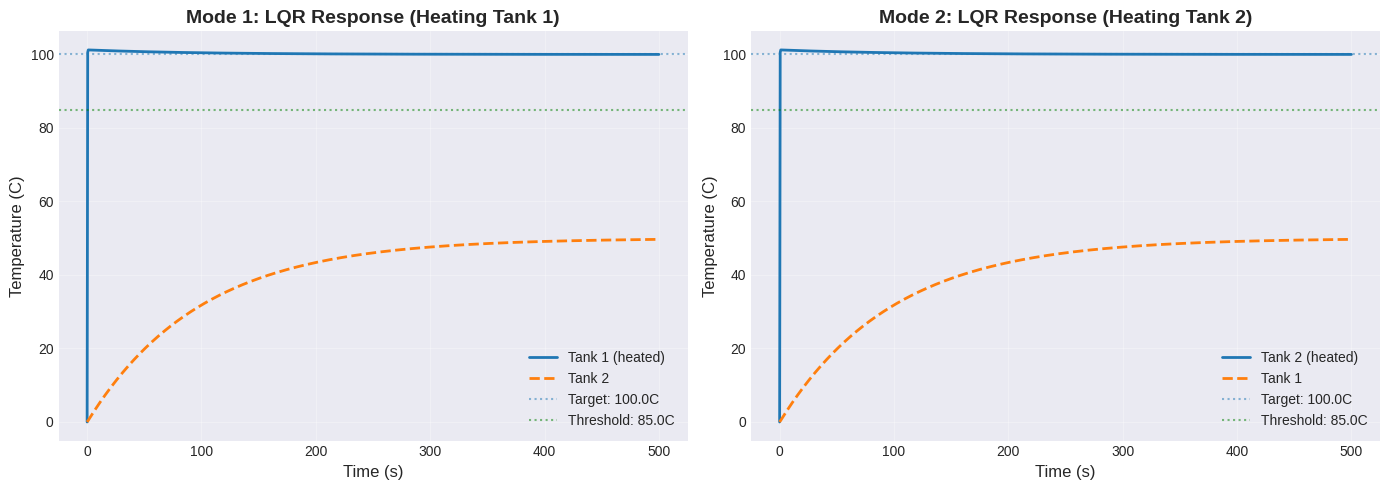

In [18]:
a1, a2, b1, b2 = 0.01, 0.01, 0.005, 0.005
x1_setpoint, x2_setpoint = 100.0, 100.0
t1, t2 = 15.0, 15.0

# System matrices
A = np.array([[-a1, b1], [b2, -a2]])
C, D = np.eye(2), np.zeros((2, 1))

def compute_lqr_controller(A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @ B.T @ P
    A_cl = A - B @ K
    return K, A_cl, cp.ss(A_cl, B, C, D)

B1 = np.array([[1.0], [0.0]])
xe_mode1 = np.array([[x1_setpoint], [(b2/a2) * x1_setpoint]])
u1e = a1 * x1_setpoint - b1 * xe_mode1[1, 0]
K1, A1_cl, sys1_cl = compute_lqr_controller(A, B1, np.diag([10.0, 1.0]), np.array([[0.1]]))

B2 = np.array([[0.0], [1.0]])
xe_mode2 = np.array([[(b1/a1) * x2_setpoint], [x2_setpoint]])
u2e = a2 * x2_setpoint - b2 * xe_mode2[0, 0]
K2, A2_cl, sys2_cl = compute_lqr_controller(A, B2, np.diag([1.0, 10.0]), np.array([[0.1]]))

t_sim = np.linspace(0, 500, 1000)
x0 = np.array([0, 0])

def simulate_mode(x, t, K, xe, ue, A, B):
    x = x.reshape(-1, 1)
    u = -K @ (x - xe) + ue
    return (A @ x + B * u).flatten()

x_mode1 = odeint(lambda x, t: simulate_mode(x, t, K1, xe_mode1, u1e, A, B1), x0, t_sim)
x_mode2 = odeint(lambda x, t: simulate_mode(x, t, K2, xe_mode2, u2e, A, B2), x0, t_sim)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
modes = [
    (x_mode1, 'Mode 1: LQR Response (Heating Tank 1)', x1_setpoint - t1, x1_setpoint, 0, 1),
    (x_mode2, 'Mode 2: LQR Response (Heating Tank 2)', x2_setpoint - t2, x2_setpoint, 1, 0)
]

for ax, (x_data, title, thresh, target, heated_idx, other_idx) in zip(axes, modes):
    ax.plot(t_sim, x_data[:, heated_idx], linewidth=2, label=f'Tank {heated_idx+1} (heated)')
    ax.plot(t_sim, x_data[:, other_idx], '--', linewidth=2, label=f'Tank {other_idx+1}')
    ax.axhline(y=target, linestyle=':', alpha=0.5, label=f'Target: {target}C')
    ax.axhline(y=thresh, color='g', linestyle=':', alpha=0.5, label=f'Threshold: {thresh}C')
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Temperature (C)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part (b): Parametric Guards with Steady-State Error Tolerance

In [19]:
tolerance_1 = t1
tolerance_2 = t2

def check_guards_mode1(x):
    x1, x2 = x[0], x[1]
    
    tank1_at_target = (x1 >= x1_setpoint - tolerance_1) and (x1 <= x1_setpoint + tolerance_1)
    
    tank2_at_equilibrium = abs(x2 - xe_mode1[1, 0]) <= tolerance_1
    both_at_equilibrium = tank1_at_target and tank2_at_equilibrium
    
    if both_at_equilibrium:
        return 'turnoff'
    elif tank1_at_target and (x2 < x2_setpoint - tolerance_2):
        return 'toggle'
    else:
        return 'continue'

def check_guards_mode2(x):
    x1, x2 = x[0], x[1]
    
    tank2_at_target = (x2 >= x2_setpoint - tolerance_2) and (x2 <= x2_setpoint + tolerance_2)
    
    tank1_at_equilibrium = abs(x1 - xe_mode2[0, 0]) <= tolerance_2
    both_at_equilibrium = tank2_at_target and tank1_at_equilibrium
    
    if both_at_equilibrium:
        return 'turnoff'
    elif tank2_at_target and (x1 < x1_setpoint - tolerance_1):
        return 'toggle'
    else:
        return 'continue'

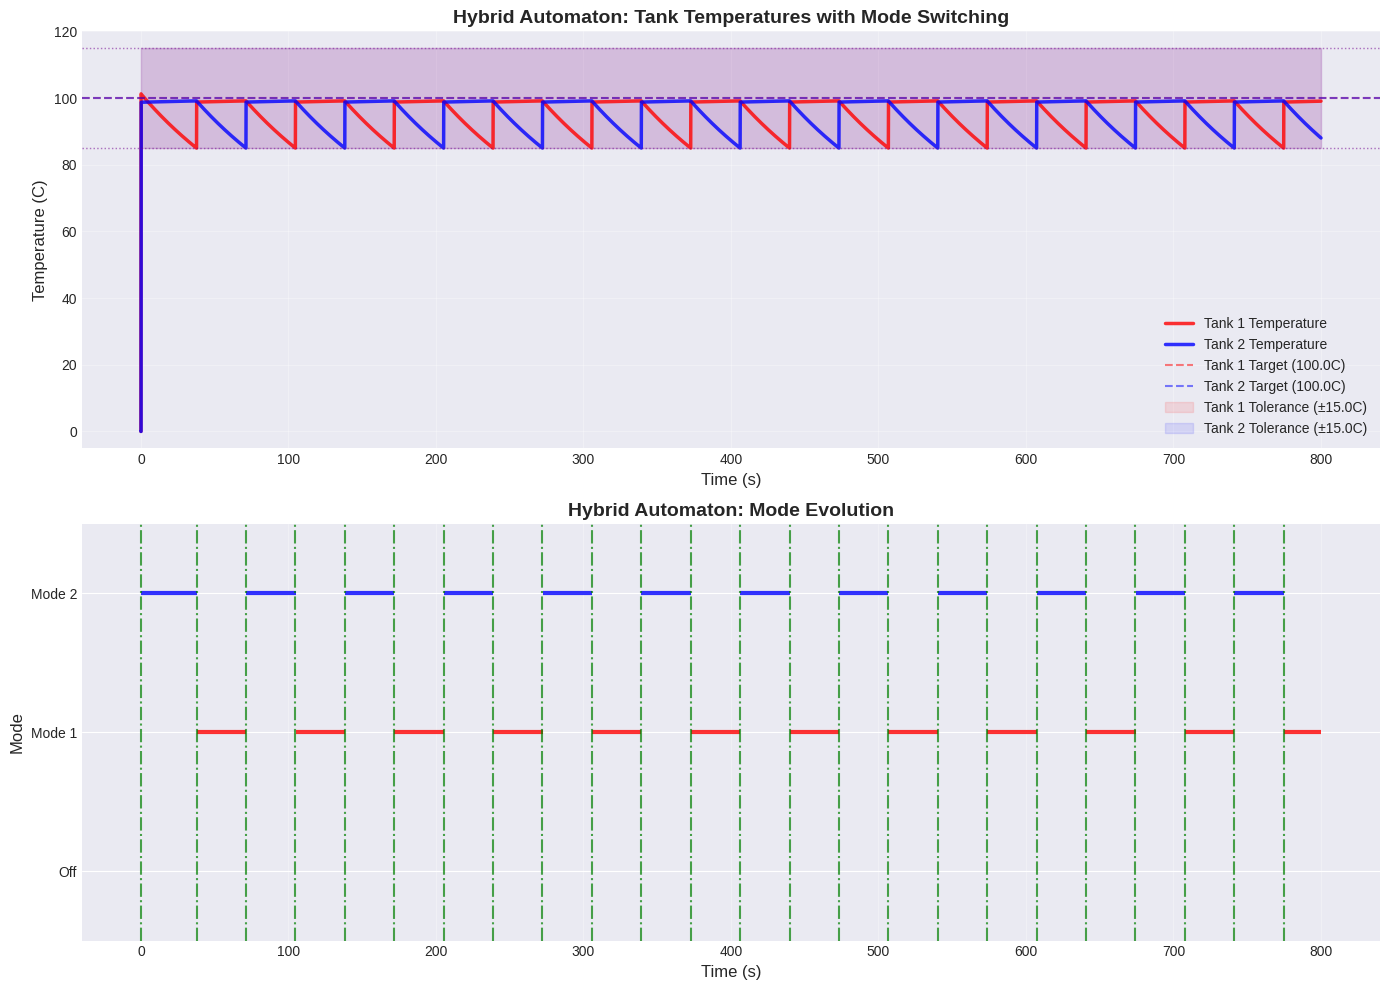

In [20]:
def simulate_hybrid_system(x0, t_max, dt=0.1, initial_mode=1):
    t, x, mode = 0, np.array(x0, dtype=float), initial_mode
    t_history, x_history, mode_history, events = [t], [x.copy()], [mode], []
    
    while t < t_max:
        guard_decision = check_guards_mode1(x) if mode == 1 else check_guards_mode2(x) if mode == 2 else None
        
        if guard_decision == 'turnoff':
            events.append({'time': t, 'from_mode': mode, 'to_mode': 0, 'state': x.copy()})
            break
        elif guard_decision == 'toggle':
            old_mode = mode
            mode = 2 if mode == 1 else 1
            events.append({'time': t, 'from_mode': old_mode, 'to_mode': mode, 'state': x.copy()})
        
        x_col = x.reshape(-1, 1)
        if mode == 1:
            dx = (A @ x_col + B1 * (-K1 @ (x_col - xe_mode1) + u1e)).flatten()
        elif mode == 2:
            dx = (A @ x_col + B2 * (-K2 @ (x_col - xe_mode2) + u2e)).flatten()
        else:
            dx = (A @ x_col).flatten()
        
        x, t = x + dx * dt, t + dt
        t_history.append(t)
        x_history.append(x.copy())
        mode_history.append(mode)
    
    return np.array(t_history), np.array(x_history), np.array(mode_history), events

t_hybrid, x_hybrid, mode_hybrid, events = simulate_hybrid_system([0, 0], t_max=800, dt=0.1, initial_mode=1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(t_hybrid, x_hybrid[:, 0], linewidth=2.5, label='Tank 1 Temperature', color='red', alpha=0.8)
ax1.plot(t_hybrid, x_hybrid[:, 1], linewidth=2.5, label='Tank 2 Temperature', color='blue', alpha=0.8)

ax1.axhline(y=x1_setpoint, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label=f'Tank 1 Target ({x1_setpoint}C)')
ax1.axhline(y=x2_setpoint, color='blue', linestyle='--', alpha=0.5, linewidth=1.5, label=f'Tank 2 Target ({x2_setpoint}C)')
ax1.axhline(y=x1_setpoint - tolerance_1, color='red', linestyle=':', alpha=0.3, linewidth=1)
ax1.axhline(y=x1_setpoint + tolerance_1, color='red', linestyle=':', alpha=0.3, linewidth=1)
ax1.fill_between(t_hybrid, x1_setpoint - tolerance_1, x1_setpoint + tolerance_1, color='red', alpha=0.1, label=f'Tank 1 Tolerance (±{tolerance_1}C)')
ax1.axhline(y=x2_setpoint - tolerance_2, color='blue', linestyle=':', alpha=0.3, linewidth=1)
ax1.axhline(y=x2_setpoint + tolerance_2, color='blue', linestyle=':', alpha=0.3, linewidth=1)
ax1.fill_between(t_hybrid, x2_setpoint - tolerance_2, x2_setpoint + tolerance_2, color='blue', alpha=0.1, label=f'Tank 2 Tolerance (±{tolerance_2}C)')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Temperature (C)', fontsize=12)
ax1.set_title('Hybrid Automaton: Tank Temperatures with Mode Switching', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(-5, 120)

mode_colors = {0: 'gray', 1: 'red', 2: 'blue'}
mode_names = {0: 'Off', 1: 'Mode 1 (Heat Tank 1)', 2: 'Mode 2 (Heat Tank 2)'}

for i in range(len(t_hybrid)-1):
    ax2.hlines(y=mode_hybrid[i], xmin=t_hybrid[i], xmax=t_hybrid[i+1], 
               colors=mode_colors[mode_hybrid[i]], linewidth=3, alpha=0.8)

for event in events:
    ax2.axvline(x=event['time'], color='green', linestyle='-.', alpha=0.7, linewidth=1.5)

ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel('Mode', fontsize=12)
ax2.set_title('Hybrid Automaton: Mode Evolution', fontsize=14, fontweight='bold')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Off', 'Mode 1', 'Mode 2'])
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_ylim(-0.5, 2.5)

plt.tight_layout()
plt.show()

## Lince Program

Sent this code to https://lmf.di.uminho.pt/lince-2.0/

```python
a1:= 0.01; a2:= 0.01;
b1:= 0.005; b2:= 0.005;
x1:= 0; x2:=0;
state:=1;
xe1:=100; xe2:=100;
t1:=15; t2:=15;
k1:=0.31; k2:=0.077;
while true {
	if state==0 then{
  	x1'= -a1*x1+b1*x2 for 7;
    x2'= -a2*x2+b2*x1 for 7;
    if x1<=0.8*80 then state:=1;
    else if x2<=0.8*80 then state:=2;
  }
  else if state==1 then{
    x1'= (-a1-k1)*x1 + (b1-k2)*x2 + xe1*k1 for 7;
    x2'= -a2*x2+b2*x1 for 7;
    if (x1>=100-t1 && x2<=0.8*80) || (x2<=0 && x1 >= 20) then state:=2;
    else if x1>=100-t1 then state:=0;
  }
  else if state==2 then{
    x2'= (-a2-k1)*x2 + (b2-k2)*x1 + xe2*k1 for 7;
    x1'= -a1*x1+b1*x2 for 7;
    if (x2>=100-t2 && x1<=0.8*80) || (x1<=0 && x2 >= 20) then state:=1;
    else if x2>=100-t2 then state:=0;
  }
}
----
until 10000
vars x1, x2, state
```

![](./lince_simulation.png)